# fig2B_C

Code to make figures for the looming comparison figure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle
import seaborn as sns

import utils

import matplotlib
# Set some global plotting styles
matplotlib.rcParams['axes.linewidth'] = 3
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10

%matplotlib notebook
%load_ext autoreload
%autoreload

In [2]:
# Set some variables
ddisp = 0.5
dispcm = 2
dispres=2000

In [3]:
display, tres, spatLUT, spatLUT_inv, h, dSc, dz, fresnel, fresdisplay = utils.read_display(
    'display-dSc_h_0.1_fresdisplay.pickle')
fr = np.zeros((dispres*2,dispres*2))
fr[dispres:,dispres:] = fresdisplay
fr[dispres:,:dispres] = fresdisplay[:,::-1] 
fr[:dispres,:dispres] = fresdisplay[::-1,::-1]
fr[:dispres,dispres:] = fresdisplay[::-1,:] 

dy = np.concatenate((display[::-1,:,:],display),axis=0)
dy[:dispres,:,1] = dispres - dy[:dispres,:,1]
dy[dispres:,:,1] = dispres + dy[dispres:,:,1]

dz = np.concatenate((dy[:,::-1,:],dy[:,:,:]),axis=1)
dz[:,:dispres,0] = dispres - dz[:,:dispres,0]
dz[:,dispres:,0] = dispres + dz[:,dispres:,0]

# Figure 2a -- Looming context

# Figure 2b -- Graph/quantification of looming implications

In [4]:
# Get a visual angle trajectory for all |R/V| values from Dunn et al.
t = 10 #seconds
rad = np.zeros((5,t*1000))
th = np.zeros((5,t*1000))
rv = [0.255, 0.490, 0.730, 0.980, 1.450]
for i in range(rad.shape[0]):
    rad[i,:], th[i,:] = utils.genRadFromRV(np.sqrt(ddisp**2+1), rv[i], t)

/home/twd/Dropbox/snell/snell_tool/figures/utils.py:267: RuntimeWarning: divide by zero encountered in true_divide
  theta = 2*np.arctan(-RV/absRadt);


Workflow for this plot:
- Get absolute radius over time for each R/V, given the set distance to the screen (remember that this is independent of the dSc/h ratio for Snells's
- Draw circle in pixel space using these radii
- Get border of drawn circle
- Get projection onto sphere of border pixels
- Sort projected pixels
- Approximate solid angle using a sinusoidal projection

In [ ]:
# To regenerate solid angle quantities, set to True (note: this will take a long tim)
regenerate = False

In [5]:
if regenerate:
    per = 10
    sAng = np.zeros((5,rad.shape[1]//per,))
    for j in [0,4]:
        for i in range(0,sAng.shape[1]):
            if i % 100 == 0:
                print(i)
            im = np.zeros((dispres*2+1,dispres+1),dtype='bool')
            utils.drawCirc(im,r=round(rad[j,i*per]*dispres/dispcm).astype('int32'),h=round(1*dispres/dispcm),k=2000)
            border = utils.get_border(im)
            xxx, psi_, theta_ = utils.border_to_sphere(border,h = round(ddisp*dispres/dispcm),center=dispres)

            # Sort psi, theta
            mean_y = np.mean(border[0])
            mean_x = np.mean(border[1])
            diff_y = border[0]-mean_y
            diff_x = border[1]-mean_x
            a = np.argsort(np.arctan2(diff_y,diff_x))

            psi_ = psi_[a]
            theta_ = theta_[a]

            psi_[np.isnan(psi_)] = 0 # for pixels at (0,0,-h)

            sAng[j,i] = utils.get_solid_angle(psi_, theta_-np.pi/2)

    per = 10
    sAng_snell_ = np.zeros((5,rad.shape[1]//per,))
    for j in [0,4]:
        for i in range(0,sAng.shape[1]):
            if i % 100 == 0:
                print(i)
            im = np.zeros((dispres*2+1,dispres+1),dtype='bool')
            utils.drawCirc(im,r=round(rad[j,i*per]*dispres/dispcm).astype('int32'),h=round(1*dispres/dispcm),k=2000)

            im = np.concatenate((np.zeros_like(im),im),axis=1)
            im = utils.snell_distort(dz,im[:-1,:-2],dispres)

            border = utils.get_border(im[:,2000:])
            xxx, psi_, theta_ = utils.border_to_sphere(border,h = round(ddisp*dispres/dispcm),center=dispres)

            # Sort psi, theta
            mean_y = np.mean(border[0])
            mean_x = np.mean(border[1])
            diff_y = border[0]-mean_y
            diff_x = border[1]-mean_x
            a = np.argsort(np.arctan2(diff_y,diff_x))

            psi_ = psi_[a]
            theta_ = theta_[a]

            sAng_snell_[j,i] = utils.get_solid_angle(psi_, theta_-np.pi/2)
            
    # Save these variables
    f = open('looming_variables.pickle','wb')
    cPickle.dump(rad,f)
    cPickle.dump(th,f)
    cPickle.dump(sAng,f)
    cPickle.dump(sAng_snell_,f)
    f.close()

0
100
200
300
400
500
600
700
800
900


C:\Users\TWD\Dropbox\snell\snellutil\utils.py:225: RuntimeWarning: divide by zero encountered in longlong_scalars
  psi = np.arctan(v1[1]/v1[0])
C:\Users\TWD\Dropbox\snell\snellutil\utils.py:225: RuntimeWarning: invalid value encountered in longlong_scalars
  psi = np.arctan(v1[1]/v1[0])


0
100
200
300
400
500
600
700
800
900


C:\Users\TWD\Anaconda3\envs\tf1\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\TWD\Anaconda3\envs\tf1\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [9]:
# Load these variables
f = open('looming_variables.pickle','rb')
rad = cPickle.load(f)
th = cPickle.load(f)
sAng = cPickle.load(f)
sAng_snell_ = cPickle.load(f)
f.close()

In [10]:
# Get a visual angle trajectory for all |R/V| values from Temizer et al. (just the slowest approach speed)
t = 10 #seconds
tem_ddisp = 1
rad_tem = np.zeros((1,t*1000))
th_tem = np.zeros((1,t*1000))
rv = [0.150]
for i in range(rad_tem.shape[0]):
    rad_tem[i,:], th_tem[i,:] = utils.genRadFromRV(tem_ddisp, rv[i], t)
    
th_tem = th_tem[0,::10]
th_fast = th[0,::10]
th_slow = th[4,::10]

/home/twd/Dropbox/snell/snell_tool/figures/utils.py:267: RuntimeWarning: divide by zero encountered in true_divide
  theta = 2*np.arctan(-RV/absRadt);


In [11]:
temrad = 2*np.pi*(1-np.cos(th_tem/2))

# For the snell corrected temizer solid angle
the = np.linspace(0,50,10000)
the_tild = utils.temizer(the)

# The Snell-adjusted critical visual angle
th_tem_snell = np.zeros_like(th_tem)
for i in range(len(th_tem_snell)):
    adj = the[utils.find_nearest(the_tild,th_tem[i]/2)]
    temrad_adj = 2*np.pi*(1-np.cos(adj*np.pi/180))
    th_tem_snell[i] = temrad_adj

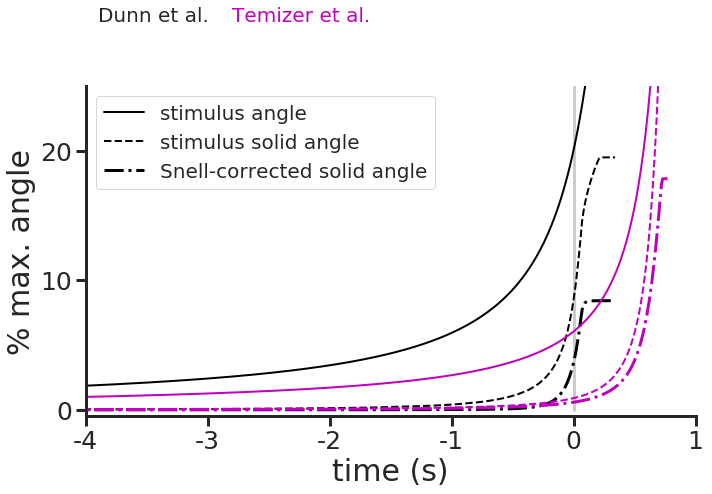

In [12]:
# Align traces to published critical angles
dunn_start = 165
tem_start = 122

plt.figure(figsize=(10,6))
sns.set_style('ticks',{"xtick.major.size": "10", "ytick.major.size": "10",'axes.linewidth': 3})

sns.set_palette(sns.color_palette("tab10"))
plt.plot([800, 800],[0,1],'k',alpha=0.2,linewidth=3)

plt.plot(th_fast[dunn_start:]/np.pi,'k',label='stimulus angle',linewidth=2)
plt.plot(sAng[0,dunn_start:]/(2*np.pi),'--k',label='stimulus solid angle',linewidth=2)
plt.plot(sAng_snell_[0,dunn_start:]/(2*np.pi),'-.k', label='Snell-corrected solid angle',linewidth=3)
plt.plot(th_tem[tem_start:]/np.pi, 'm',linewidth=2)
plt.plot(temrad[tem_start:]/(2*np.pi), '--m',linewidth=2)
plt.plot(th_tem_snell[tem_start:]/(2*np.pi), '-.m',linewidth=3)

plt.ylabel('% max. angle',size=30)
plt.xlabel('time (s)',size=30)
plt.xticks([0, 200, 400, 500, 600, 700, 800, 900],['0','2','-4','-3','-2','-1','0', '1'])
plt.xlim([400,900])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1],['0','10','20','30','40', '50'])
plt.ylim([-0.01,0.5])
plt.legend(fontsize=20)

ax = plt.gca()
ax.tick_params(width=3,labelsize=25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.text(410,0.6,'Dunn et al.',fontsize=20)
plt.text(520,0.6,'Temizer et al.',color='m',fontsize=20)
plt.tight_layout()
#plt.savefig('./paper/v4/fig1e_v4_bw_temizer.pdf')

# Figure 1f -- bar graphs to support fix

In [13]:
# Spherical cap formula -- temizer no snell
ang = 21.7/2
temrad = 2*np.pi*(1-np.cos(ang*np.pi/180))
ang_u = (21.7+2.5*1.96)/2
temrad_u = 2*np.pi*(1-np.cos(ang_u*np.pi/180))
ang_l = (21.7-2.5*1.96)/2
temrad_l = 2*np.pi*(1-np.cos(ang_l*np.pi/180))

In [14]:
# For the snell corrected temizer solid angle
the = np.linspace(0,20,1000)
the_tild = utils.temizer(the)

# The Snell-adjusted critical visual angle
adj = the[utils.find_nearest(the_tild*180/np.pi,21.7/2)]*2
temrad_adj = 2*np.pi*(1-np.cos(adj/2*np.pi/180))

# Get the 95% CI for the snell-adjusted size
adj_u = the[utils.find_nearest(the_tild*180/np.pi,(21.7+2.5*1.96)/2)]*2
temrad_adj_u = 2*np.pi*(1-np.cos(adj_u/2*np.pi/180))

adj_l = the[utils.find_nearest(the_tild*180/np.pi,(21.7-2.5*1.96)/2)]*2
temrad_adj_l = 2*np.pi*(1-np.cos(adj_l/2*np.pi/180))

In [15]:
frac = np.pi
frac2 = 2*np.pi

rad = np.array([0.38, 1.26])/frac
err_rad_dunn = 1.3*np.pi/180*1.96/frac
err_rad_tem = 2.5*np.pi/180*1.96/frac

ster = np.array([temrad, sAng[4,800]])/frac2 #sAng[4,800] corresponds to the time point when stim reaches crit visual angle
err_ster_tem = abs(np.array([temrad_l, temrad_u])-temrad)/frac2
err_ster_dunn = abs(np.array([sAng[4,int(np.round(utils.find_nearest(th[4,:]*180/np.pi,72.0 - 1.3*1.96)/10))],
                         sAng[4,int(np.round(utils.find_nearest(th[4,:]*180/np.pi,72.0 + 1.3*1.96)/10))]]) - sAng[4,800])/frac2

ster_snell = np.array([temrad_adj, sAng_snell_[4,800]])/frac2
err_ster_snell_tem = abs(np.array([temrad_adj_l, temrad_adj_u])-temrad_adj)/frac2
err_ster_snell_dunn = np.array([sAng_snell_[4,int(np.round(utils.find_nearest(th[4,:]*180/np.pi,72.0 - 1.3*1.96)/10))],
                         sAng_snell_[4,int(np.round(utils.find_nearest(th[4,:]*180/np.pi,72.0 + 1.3*1.96)/10))]]) \
                            - sAng_snell_[4,800]
err_ster_snell_dunn = abs(err_ster_snell_dunn)/frac2

## Do the plot

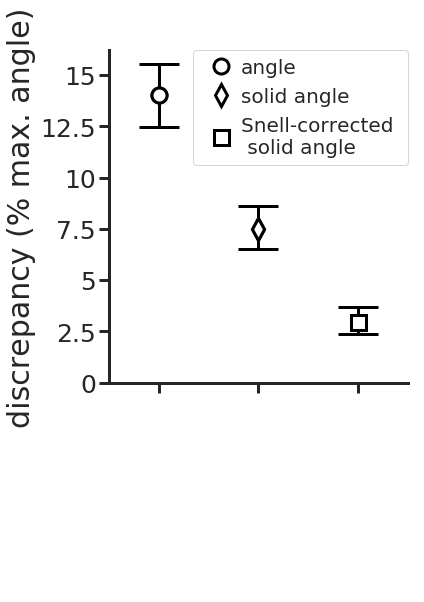

In [16]:
plt.figure(figsize=(6,8))
a = sns.color_palette("tab10")

plt.errorbar(1,rad[1]-rad[0],np.sqrt(err_rad_tem**2+err_rad_dunn**2),color='k',
             linewidth=3,marker='o',markersize=15,markerfacecolor='white',markeredgewidth=3,capsize=20,)
plt.plot(1,rad[1]-rad[0],color='k',marker='o',markersize=15,markerfacecolor='white',
         markeredgewidth=3,linestyle='None',label='angle')

tot_err_ster = np.array([np.sqrt(err_ster_tem[0]**2 + err_ster_dunn[0]**2), np.sqrt(err_ster_tem[1]**2 + err_ster_dunn[1]**2)])
plt.errorbar(2,ster[1]-ster[0],tot_err_ster[:,np.newaxis],color='k',
             linewidth=3,marker='d',markersize=15,markerfacecolor='white',markeredgewidth=3,capsize=20)
plt.plot(2,ster[1]-ster[0],color='k',marker='d',markersize=15,markerfacecolor='white',
         markeredgewidth=3,linestyle='None',label='solid angle')

tot_err_snell = np.array([np.sqrt(err_ster_snell_tem[0]**2 + err_ster_snell_dunn[0]**2), 
                          np.sqrt(err_ster_snell_tem[1]**2 + err_ster_snell_dunn[1]**2)])
plt.errorbar(3,ster_snell[1]-ster_snell[0],tot_err_snell[:,np.newaxis],color='k',
             linewidth=3,marker='s',markersize=15,markerfacecolor='white',markeredgewidth=3,capsize=20)
plt.plot(3,ster_snell[1]-ster_snell[0],color='k',marker='s',markersize=15,markerfacecolor='white',
         markeredgewidth=3,linestyle='None',label='Snell-corrected \n solid angle')

plt.xticks([1,2,3],['angle', 'solid angle', 'Snell-corrected \n solid angle'],size=15,rotation='vertical')
ax = plt.gca()
plt.setp(ax.get_xticklabels(), color="white")
plt.ylabel('discrepancy (% max. angle)',size=30)

ax = plt.gca()
ax.tick_params(width=3,labelsize=25)
plt.xlim([0.5,3.5])
plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.30],['0','2.5','5','7.5','10', '12.5', '15'])
plt.legend(fontsize=20,handletextpad=0,borderaxespad=0)
sns.despine()
plt.tight_layout()
#plt.savefig('./paper/v4/fig1f_v3_frac_ball.pdf',bbox_inches='tight')